In this notebook: try without prefactor

In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

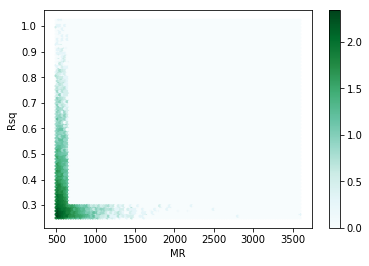

In [3]:
# Check the data
ax = sideband_data['MultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [12]:
def razor_p(MR, Rsq, P, n1, n2, A, B, MRMin, RsqMin):
    """Computes razor probability density (numpy version)."""
    term1 = P * np.power((MR-MRMin+A)/A, 1./n1) * np.power((Rsq-RsqMin+B)/B, 1./n2)
    prob = np.exp(-term1) 
    return prob

def razor_int(P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sideband):
    """Computes razor integral in a rectangular region"""
    func = lambda y, x: razor_p(x, y, P, n1, n2, A, B, sideband.MRMin_, sideband.RsqMin_)
    RsqLow = lambda x: RsqMin
    RsqHigh = lambda x: RsqMax
    return sp.integrate.dblquad(func, MRMin, MRMax, RsqLow, RsqHigh)[0]

def razor_norm(P, n1, n2, A, B, sideband):
    norm_MR_sideband = razor_int(P, n1, n2, A, B, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_, sideband)
    norm_Rsq_sideband = razor_int(P, n1, n2, A, B, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_, sideband)
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, P, n1, n2, A, B, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, P, n1, n2, A, B, sideband.MRMin_, sideband.RsqMin_)
    norm = razor_norm(P, n1, n2, A, B, sideband)
    return nevents*p/norm

In [14]:
# Using scipy's integration functionality we can directly compute the razor pdf integral numerically.
# This may allow us to move to pdfs whose norm is not analytically calculable.  

class RazorIntegral(th.Op):
    """Inputs: P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin
       Output: pdf integral"""
    __props__ = ()
    epsilon = 1e-7
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = T.dscalar()
        return th.Apply(self, inputs, [output])
    
    def perform(self, node, inputs, output_storage):
        P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        func = lambda y, x: razor_p(x, y, P, n1, n2, A, B, sidebandMRMin, sidebandRsqMin)
        RsqLow = lambda x: RsqMin
        RsqHigh = lambda x: RsqMax
        pdf_integral = sp.integrate.dblquad( func, MRMin, MRMax, RsqLow, RsqHigh )[0]
        
        res = output_storage[0]
        res[0] = np.array(pdf_integral)
        
    def grad(self, inputs, g):
        P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        out_grad = g[0]
        e = self.epsilon
        P_grad = (razor_integral(P + e, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P - e, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        n1_grad = (razor_integral(P, n1 + e, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n1 - e, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        n2_grad = (razor_integral(P, n1, n2 + e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n1, n2 - e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        A_grad = (razor_integral(P, n1, n2, A + e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n1, n2, A - e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        B_grad = (razor_integral(P, n1, n2, A, B + e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n1, n2, A, B - e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        MRMin_grad = MRMin.zeros_like()
        MRMax_grad = MRMax.zeros_like()
        RsqMin_grad = RsqMin.zeros_like()
        RsqMax_grad = RsqMax.zeros_like()
        sidebandMRMin_grad = sidebandMRMin.zeros_like()
        sidebandRsqMin_grad = sidebandRsqMin.zeros_like()
        return [out_grad * gr for gr in [P_grad, n1_grad, n2_grad, A_grad, B_grad, 
                                         MRMin_grad, MRMax_grad, RsqMin_grad, RsqMax_grad,
                                         sidebandMRMin_grad, sidebandRsqMin_grad]]
        
razor_integral = RazorIntegral()

In [16]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, P, n1, n2, A, B, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.P = P
        self.n1 = n1
        self.n2 = n2
        self.A = A
        self.B = B
        self.sideband = sideband
    
    def norm(self):
        P = self.P
        n1 = self.n1
        n2 = self.n2
        A = self.A
        B = self.B
        norm_MR_sideband = razor_integral(P, n1, n2, A, B, self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax, self.sideband.MRMin, self.sideband.RsqMin)
        norm_Rsq_sideband = razor_integral(P, n1, n2, A, B, self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax, self.sideband.MRMin, self.sideband.RsqMin)
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        P = self.P
        n1 = self.n1
        n2 = self.n2
        A = self.A
        B = self.B
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        term1 = P * T.pow((MR-MRMin+A)/A, 1./n1) * T.pow((Rsq-RsqMin+B)/B, 1./n2 )
        logprob = (-term1)
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, A>0, B>0, P>0, n1>0., n2>0.)

In [8]:
# To visualize fits in 3D

def compare_fit_and_data(trace, d, sideband):
    xmin = sideband.MRMin_
    xmax = sideband.MRSidebandMax_
    ymin = sideband.RsqMin_
    ymax = sideband.RsqSidebandMax_
    
    xstep = 10.
    ystep = 0.01
    nx = int((xmax-xmin)/xstep)
    ny = int((ymax-ymin)/ystep)
    gridx_ = np.arange(xmin, xmax+xstep, xstep)
    gridy_ = np.arange(ymin, ymax+ystep, ystep)
    gridx, gridy = np.meshgrid(gridx_, gridy_)

    # Data
    binstepx = (xmax-xmin)/10.
    binstepy = (ymax-ymin)/10.
    data_bins = (np.arange(xmin, xmax+binstepx, binstepx), np.arange(ymin, ymax+binstepy, binstepy)) 
    data_hist = np.log(np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]).T - np.log(binstepx*binstepy)
    data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., 
                                         (data_bins[1][:-1]+data_bins[1][1:])/2.)
    data_norm = len(d)

    # Fit 
    pdf_vals = np.zeros((nx, ny))
    pdf_vals = np.log(razor_p_sidebandnormalized(gridx, gridy, median(trace["P"]), median(trace["n"]), 
                                             median(trace["A"]), median(trace["B"]), data_norm, sideband=sideband))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(gridx, gridy, pdf_vals)
    ax.plot_surface(data_binsx, data_binsy, data_hist)
    ax.set_xlabel('MR (GeV)')
    ax.set_ylabel('Rsq (GeV)')
    ax.set_zlabel('log density')
    plt.show()
    
# Visualize fit residuals 
def vis_resids(trace, d, sideband):
    xmin = sideband.MRMin_
    xmax = min(2000, sideband.MRSidebandMax_)
    ymin = sideband.RsqMin_
    ymax = sideband.RsqSidebandMax_

    # Data
    nbinsx = 6.
    nbinsy = 6.
    if sideband.RsqSidebandMax_ > 1.:
        nbinsx = 6.
        nbinsy = 7.
    binstepx = (xmax-xmin)/nbinsx
    binstepy = (ymax-ymin)/nbinsy
    data_bins = [np.arange(xmin, xmax+binstepx, binstepx), np.arange(ymin, ymax+binstepy, binstepy)]
    if len(data_bins[1]) < nbinsy+1:
        data_bins[1].append(ymax)
    data_hist = np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]
    data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., 
                                         (data_bins[1][:-1]+data_bins[1][1:])/2., indexing='ij')
    data_norm = len(d[ (d['MR'] < xmax) & (d['Rsq'] < ymax) ])
    
    P = median(trace["P"])
    n = median(trace["n"])
    A = median(trace["A"])
    B = median(trace["B"])
    pdf_vals = np.zeros((len(data_bins[0])-1, len(data_bins[1])-1))
    fit_norm = razor_norm(P, n, A, B, sideband)
    for bx,mr_low in enumerate(data_bins[0][:-1]):
        for by,rsq_low in enumerate(data_bins[1][:-1]):
            mr_high = data_bins[0][bx+1]
            rsq_high = data_bins[1][by+1]
            integral = razor_int(P, n, A, B, mr_low, mr_high, rsq_low, rsq_high, sideband) * data_norm / fit_norm
            pdf_vals[bx,by] = integral

    resids = np.clip(data_hist / pdf_vals, 0., 3.)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(data_binsx, data_binsy, resids)
    ax.set_xlabel('MR (GeV)')
    ax.set_ylabel('Rsq')
    ax.set_zlabel('Data/Fit')
    if ax.get_xlim()[1] > 2000:
        ax.set_xlim(xmin, 2000)
    ax.set_zbound(0., 3.)
    plt.show()

In [9]:
# Get nsigma values in every sideband bin

bins_hadronic = ([500, 575, 650, 750, 900, 1200, 1600, 2500, 4000], [0.25,0.30,0.41,0.52,0.64,1.5])
bins_leptonic = ([400, 475, 550, 700, 900, 1200, 1600, 2500, 4000], [0.15,0.20,0.25,0.30,0.41,0.52,0.64,1.5])

def get_data_yield(d, bin_coords):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    return len(d[ (d['MR'] > mrmin) & (d['MR'] < mrmax) & (d['Rsq'] > rsqmin) & (d['Rsq'] < rsqmax) ])

def get_pred_yields(trace, bin_coords, sband, norm):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    yields = []
    for i in range(len(trace)):
        P = trace['P'][i]
        n = trace['n'][i]
        A = trace['A'][i]
        B = trace['B'][i]
        full_int = razor_norm(P, n, A, B, sband)
        yields.append( razor_int(P, n, A, B, mrmin, mrmax, rsqmin, rsqmax, sband)*norm/full_int )
    return np.array(yields)

def get_nsigma(obs, preds):
    central_pred = median(preds)
    total = float(len(preds))
    if obs > central_pred:
        cdf = 1 - len(preds[preds > obs])/total
    else:
        cdf = len(preds[preds < obs])/total
    print obs, central_pred, sp.stats.iqr(preds), cdf
    return sp.stats.norm.ppf(cdf)

def get_nsigmas(trace, d, box):
    bins = bins_hadronic
    sband = hadronic_sideband
    if 'Lepton' in box:
        bins = bins_leptonic
        sband = leptonic_sideband
    norm = len(d)
    nsigmas = {}
    for ix, mrlow in enumerate(bins[0][:-1]):
        mrhigh = bins[0][ix+1]
        # only consider bins in sideband (2 bins in MR, 1 in Rsq)
        if ix < 2:
            iymax = len(bins[1])-1
        else:
            iymax = 1
        for iy, rsqlow in enumerate(bins[1][:iymax]):
            rsqhigh = bins[1][iy+1]
            this_bin = (mrlow, mrhigh, rsqlow, rsqhigh)
            this_yield = get_data_yield(d, this_bin)
            this_preds = get_pred_yields(trace, this_bin, sband, norm)
            nsigmas[this_bin] = get_nsigma(this_yield, this_preds)
    return nsigmas

In [17]:
# Model setup and training

def build_model(data, nbtags, box='MultiJet',
               prior_slopes=[0.05, 0.04, 0.04, 0.0005, 0.5],
               initial_vals=[7.0, 6.3, 6.3, 1000., 0.8],
               sideband=None):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential priors on P, n, A, B
        initial_vals: test values for parameters"""
    with pm.Model() as model:
        # PDF variables
        P = pm.Exponential("P", prior_slopes[0], testval=initial_vals[0])
        n1 = pm.Exponential("n1", prior_slopes[1], testval=initial_vals[1])        
        n2 = pm.Exponential("n2", prior_slopes[2], testval=initial_vals[2])
        A = pm.Exponential("A", prior_slopes[3], testval=initial_vals[3])
        B = pm.Exponential("B", prior_slopes[4], testval=initial_vals[4])
            
        if sideband is not None:
            sband = sideband
        elif box in ['LeptonJet','LeptonMultiJet']:
            sband = leptonic_sideband
        else:
            sband = hadronic_sideband
            
        observed = data.ix[nbtags][['MR','Rsq']].values
        razor_pdf = Razor("razor_pdf", P=P, n1=n1, n2=n2, A=A, B=B, sideband=sband,
                          shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=10000, burn_period=5000):
    """Fit the model and return
        samples from the posterior"""
    with model:
        step = pm.Metropolis()
        trace = pm.sample(samples, step=step)
        #trace = pm.sample(samples)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['P','n1','n2','A','B']
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, nbtags, samples=10000, burn_period=5000, sideband=None, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, nbtags, sideband=sideband, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))

 13%|█▎        | 257/2000 [04:24<6:40:52, 13.80s/it]

ValueError: zero-size array to reduction operation minimum which has no identity

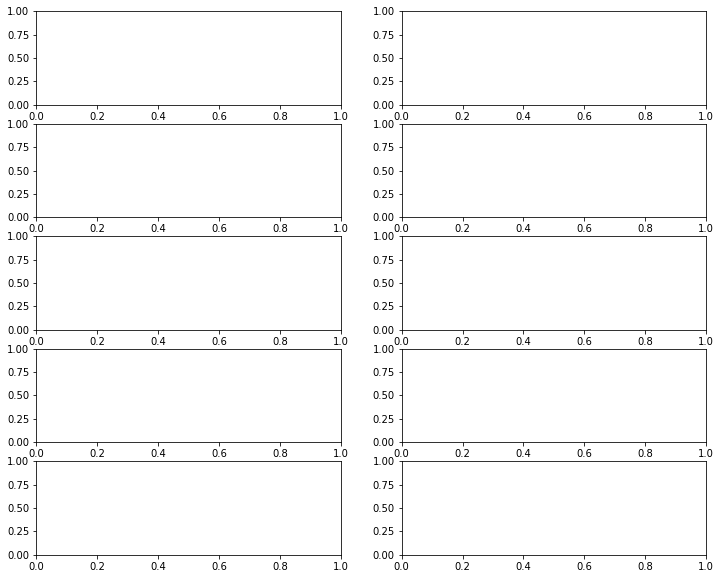

In [21]:
%matplotlib inline
trace = fit_and_plot(sideband_data['DiJet'], 0, samples=2000, burn_period=1000, box='DiJet')